In [7]:
import os
import time
import copy
import random
from tqdm import tqdm

import numpy as np 

import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from secure_ml.attack import Poison_attack_sklearn


**Train target model (Before Attack)**

In [8]:
X_train = np.load("data/X_train_p.npy", allow_pickle=True) 
y_train = np.load("data/y_train_p.npy", allow_pickle=True)
X_valid = np.load("data/X_valid_p.npy", allow_pickle=True)
y_valid = np.load("data/y_valid_p.npy", allow_pickle=True)


In [9]:
start = time.time() # Storing start time to calculate the total time taken
clf = SVC(kernel="linear")
clf.fit(X_train, y_train) # Learning
elapsed_time = time.time() - start # Total Time
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

start = time.time()
predict = clf.predict(X_valid) # Prediction with Eval data
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

print("Results..")
ac_score = metrics.accuracy_score(y_valid, predict) # Prediction results comparison
cl_report = metrics.classification_report(y_valid, predict)
print("Accuracy Rate = ", ac_score)
print(cl_report)


elapsed_time:1.2206690311431885[sec]
elapsed_time:0.03300023078918457[sec]
Results..
Accuracy Rate =  0.986
              precision    recall  f1-score   support

           3       0.99      0.98      0.99       258
           7       0.98      0.99      0.99       242

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



**Attack**

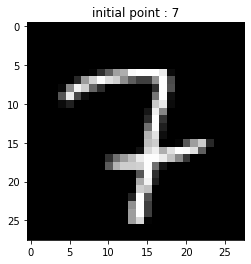

In [10]:
# initial point
initial_idx = 0
xc = X_train[initial_idx, :]
yc = y_train[initial_idx]

plt.imshow(xc.reshape(28,28),cmap='gray')
plt.title(f"initial point : {yc}")
plt.show()

In [11]:
train_idx = random.sample(list(range(1, X_train.shape[0]))
                          , 100)
X_train_ = copy.copy(X_train[train_idx,:])
y_train_ = copy.copy(y_train[train_idx])

y_train_ = np.where(y_train_ == '7', 1, -1)
y_valid_ = np.where(y_valid == '7', 1, -1)

In [12]:
attacker = Poison_attack_sklearn(clf,X_train_, y_train_, t=0.5)

xc_attacked, log = attacker.attack(xc, 1, X_valid, y_valid_, num_iterations=200)

100%|██████████| 200/200 [00:08<00:00, 23.41it/s]


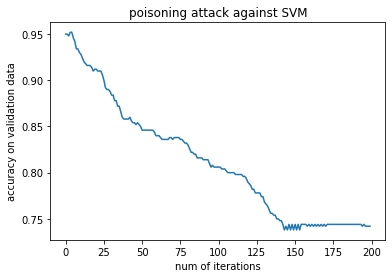

In [13]:
plt.plot(log)
plt.title("poisoning attack against SVM")
plt.xlabel("num of iterations")
plt.ylabel("accuracy on validation data")
plt.savefig("poison_loss_rn.png")
plt.show()

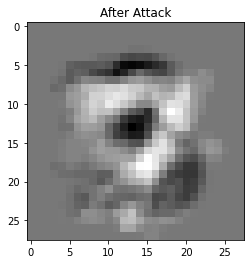

In [14]:
plt.imshow(xc_attacked.reshape(28,28),cmap='gray')
plt.title("After Attack")
plt.savefig("poison_example_rn.png")
plt.show()

In [15]:
clf = SVC(kernel="linear", C=1)
clf.fit(X_train_, y_train_)
print("before attack: ", clf.score(X_valid, y_valid_))

# After adding poinsoned data
clf = SVC(kernel="linear", C=1)
clf.fit(np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
             np.concatenate([y_train_, [-1]]))
print("after attack: ", clf.score(X_valid, y_valid_))

before attack:  0.958
after attack:  0.742
